# Dragut 2019 – empirical curve (retail phone regex)

Baseline: simple phone-number regex, labels revealed in 5-minute blocks.

In [1]:
# --- Imports and data load ---------------------------------------------------
import pandas as pd, pathlib, os, sys, re, json, numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

ROOT = pathlib.Path(os.getcwd()).parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))          # make "src" importable

RAW = ROOT / "data" / "raw" / "dragut_phone.csv"
df  = pd.read_csv(RAW)

In [2]:
# 1) Label with the simple phone-number regex
phone_pat = re.compile(r"\(?\d{3}\)?[-\s]\d{3}-\d{4}")
y_true = df["Label"].values
y_pred = df["String"].str.contains(phone_pat).astype(int).values

In [3]:
# 2) Build F1 vs annotation-minutes curve (5-minute granularity)
f1_points = []
minutes_per_row = 2          # ≈30 rows / hour
for m in range(0, 160, 5):
    rows = int(m / minutes_per_row)
    if rows == 0:
        f1 = 0.0
    else:
        f1 = precision_recall_fscore_support(
            y_true[:rows], y_pred[:rows],
            average="binary", zero_division=0
        )[2]
    f1_points.append((m, f1))

m_values, f1_values = zip(*f1_points)      #  <-- this is the X list
print(list(zip(m_values, f1_values)))

[(0, 0.0), (5, 0.0), (10, 1.0), (15, 1.0), (20, 1.0), (25, 1.0), (30, 1.0), (35, 1.0), (40, 0.8571428571428571), (45, 0.75), (50, 0.75), (55, 0.75), (60, 0.6), (65, 0.5454545454545454), (70, 0.5454545454545454), (75, 0.5454545454545454), (80, 0.5454545454545454), (85, 0.5454545454545454), (90, 0.5454545454545454), (95, 0.5454545454545454), (100, 0.7058823529411765), (105, 0.7058823529411765), (110, 0.7058823529411765), (115, 0.7058823529411765), (120, 0.7058823529411765), (125, 0.7368421052631579), (130, 0.7368421052631579), (135, 0.7368421052631579), (140, 0.7368421052631579), (145, 0.7368421052631579), (150, 0.7368421052631579), (155, 0.7368421052631579)]


In [4]:
# 3) Fit the 2-parameter log curve you already implemented
from src.curves import fit_log_curve, log_model   # your helper functions
a, b, rmse = fit_log_curve(m_values, f1_values)

Cleaned fit  a=0.046,  b=28660.0,  RMSE=0.092


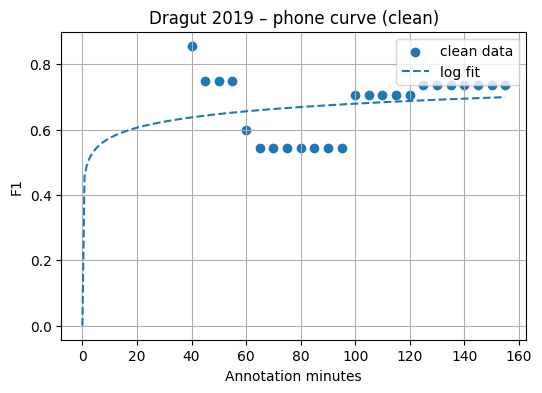

In [5]:
# 4) Plot + save
# --- CLEAN: drop points where F1 is unrealistically high ---------------
clean = [(m,f1) for m,f1 in f1_points if (f1>0) & (f1<0.9)] # keep rows with 0 < F1 < 0.9
m_values, f1_values = map(np.array, zip(*clean))

# Fit
a, b, rmse = fit_log_curve(m_values, f1_values)
print(f"Cleaned fit  a={a:.3f},  b={b:.1f},  RMSE={rmse:.3f}")

# Plot
plt.figure(figsize=(6,4))
plt.scatter(m_values, f1_values, label="clean data")
m_plot = np.linspace(0, m_values.max(), 200)
plt.plot(m_plot, a*np.log(b*m_plot + 1), '--', label="log fit")
plt.title("Dragut 2019 – phone curve (clean)")
plt.xlabel("Annotation minutes"); plt.ylabel("F1")
plt.legend(); plt.grid(True)
plt.savefig("../docs/figures/dragut_log_fit.png", dpi=120)
plt.show()


In [6]:
# 5) Persist parameters in data/curves.json
CURVES = ROOT / "data" / "curves.json"
curves = json.loads(CURVES.read_text())
curves["Dragut2019_phone"] = {"a": float(a), "b": float(b), "rmse": float(rmse)}
CURVES.write_text(json.dumps(curves, indent=2))
print("Saved →", CURVES)
pd.DataFrame(clean).to_csv("../data/curves_dragut_phone.csv", index=False)

Saved → c:\Users\zuzia\OneDrive - Temple University\Documents\MS Computational DS\Summer 2025\Research\Project\cost-utility-calculator\data\curves.json
